<a href="https://colab.research.google.com/github/willismax/ML-in-Production-30-days-sharing/blob/main/notebook/17.%E7%89%B9%E5%BE%B5%E9%81%B8%E6%93%87_Deta_Selection_%E9%90%B5%E4%BA%BA%E8%B3%BD%E7%A4%BA%E7%AF%84_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 特徵選擇

- 此為[ithome鐵人賽 Day17](https://ithelp.ithome.com.tw/articles/10264846)程式實作範例，資料集為經整理過後較簡易的[鐵達尼號資料集](https://raw.githubusercontent.com/duxuhao/Feature-Selection/master/example/titanic/clean_train.csv)，Model主要以`sklearn.ensemble.RandomForestClassifier`進行示範，程式碼參考[Machine Learning Data Lifecycle in Production](https://www.coursera.org/learn/machine-learning-data-lifecycle-in-production)課程，它是[Machine Learning Engineering for Production (MLOps) 專項課程](https://www.coursera.org/specializations/machine-learning-engineering-for-production-mlops)其中一部分。

## 下載及整理資料

In [1]:
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE, SelectKBest, SelectFromModel, chi2, f_classif
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

In [2]:
# 下載鐵達尼號資料集
!wget -O data.csv https://raw.githubusercontent.com/duxuhao/Feature-Selection/master/example/titanic/clean_train.csv

--2022-05-19 02:58:40--  https://raw.githubusercontent.com/duxuhao/Feature-Selection/master/example/titanic/clean_train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 74317 (73K) [text/plain]
Saving to: ‘data.csv’

data.csv            100%[===================>]  72.58K  --.-KB/s    in 0.007s  

2022-05-19 02:58:40 (9.45 MB/s) - ‘data.csv’ saved [74317/74317]



In [3]:
df = pd.read_csv('data.csv')
df.describe(include='all')

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,FamilySize,Name_length,IsAlone,Title,Survived
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891,891.000000
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Mr,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,529,NaN
mean,446.000000,2.308642,0.352413,-0.009884,0.523008,0.381594,-0.021100,1.102132,1.904602,-0.017408,0.602694,NaN,0.383838
std,257.353842,0.836071,0.477990,1.006520,1.102743,0.806057,0.960833,0.514624,1.613459,0.976716,0.489615,NaN,0.486592
min,1.000000,1.000000,0.000000,-2.236716,0.000000,0.000000,-0.643775,0.000000,1.000000,-1.592217,0.000000,NaN,0.000000
25%,223.500000,2.000000,0.000000,-0.613397,0.000000,0.000000,-0.490826,1.000000,1.000000,-0.750366,0.000000,NaN,0.000000
50%,446.000000,3.000000,0.000000,0.005583,0.000000,0.000000,-0.364300,1.000000,1.000000,-0.224210,1.000000,NaN,0.000000
75%,668.500000,3.000000,1.000000,0.460410,1.000000,0.000000,-0.044384,1.000000,2.000000,0.301947,1.000000,NaN,1.000000


In [4]:
# 確認有無缺失值
df.isna().sum()

PassengerId    0
Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Embarked       0
FamilySize     0
Name_length    0
IsAlone        0
Title          0
Survived       0
dtype: int64

In [5]:
# 特徵工程 (One-hot encoding)
df = pd.concat(
    [df,pd.get_dummies(df["Title"])], 
    axis=1
    )
df = df.drop("Title", 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  


In [6]:
# 切分特徵X與標籤Y
X = df.drop("Survived", 1)
Y = df["Survived"]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  


In [7]:
X.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,FamilySize,Name_length,IsAlone,Master,Miss,Mr,Mrs,Other
0,1,3,0,-0.600854,1,0,-0.503595,1,2,-0.434672,0,0,0,1,0,0
1,2,1,1,0.612019,1,0,0.734503,2,2,2.511806,0,0,0,0,1,0
2,3,3,1,-0.297635,0,0,-0.490544,1,1,-0.539904,1,0,1,0,0,0
3,4,1,1,0.384606,1,0,0.382925,1,2,1.775186,0,0,0,0,1,0
4,5,3,0,0.384606,0,0,-0.488127,1,1,-0.329441,1,0,0,1,0,0


## 定義評估模型

- 本範例採具有階層性的`sklearn.ensemble.RandomForestClassifier`訓練資料，評估結果為驗證資料集的metrics。

In [8]:
def use_RandomForestClassifier_evaluation_metrics_on_test_set(X,Y):
    X_train, X_test, Y_train, Y_test = train_test_split(
        X, Y, test_size = 0.2 ,stratify=Y, random_state = 9527)

    # 標準化
    scaler = StandardScaler().fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # RandomForestClassifier訓練模型
    model = RandomForestClassifier(criterion='entropy', random_state=9527)
    model.fit(X_train_scaled, Y_train)

    # 預測
    y_predict_result = model.predict(X_test_scaled)

    # 回傳evaluation_metrics_on_test_set
    return {
        'accuracy' : accuracy_score(Y_test, y_predict_result),
        'roc' : roc_auc_score(Y_test, y_predict_result),
        'precision' : precision_score(Y_test, y_predict_result),
        'recall' : recall_score(Y_test, y_predict_result),
        'f1' : f1_score(Y_test, y_predict_result),
        'Feature Count' : len(X.columns)
        }

### 全特徵原始成效

In [9]:
res = pd.DataFrame(use_RandomForestClassifier_evaluation_metrics_on_test_set(X,Y), index=['ALL'])
res

,accuracy,roc,precision,recall,f1,Feature Count
ALL,0.815642,0.793281,0.8,0.695652,0.744186,16


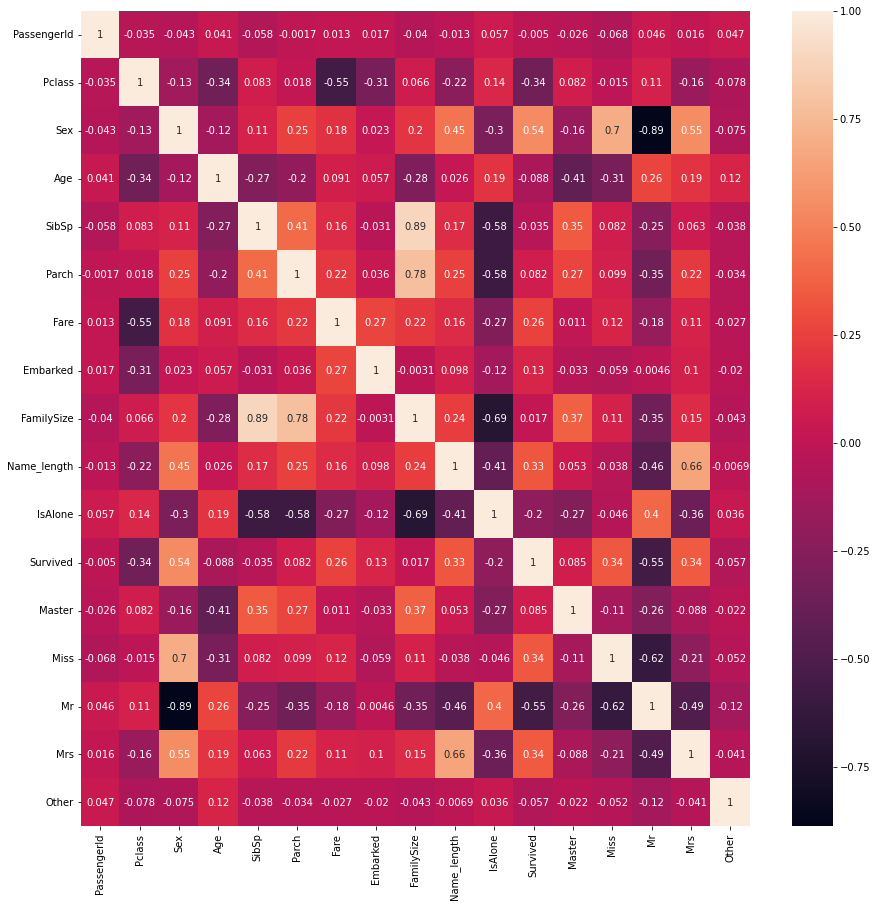

In [10]:
# Correlation Matrix
plt.figure(figsize=(15,15))
cor = df.corr() 
sns.heatmap(cor, annot=True)
plt.show()

## 過濾方法 Filter Method

### 依關聯性移除特徵

In [11]:
# 取得具有與其他部分特徵高度相關的某特徵絕對值
cor_target = abs(cor["FamilySize"])

# 選擇高度相關的特徵（閾值 = 0.2）
relevant_features = cor_target[cor_target>0.2]

# 選擇特徵名稱
names = [index for index, value in relevant_features.iteritems()]

# 刪除目標特徵
names.remove('FamilySize')

print(names)

['Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Name_length', 'IsAlone', 'Master', 'Mr']


In [12]:
res = res.append(
    pd.DataFrame(
        use_RandomForestClassifier_evaluation_metrics_on_test_set(
            X[names],
            Y), 
            index=['Remove High Corr']))
res

,accuracy,roc,precision,recall,f1,Feature Count
ALL,0.815642,0.793281,0.800000,0.695652,0.744186,16
Remove High Corr,0.782123,0.766008,0.727273,0.695652,0.711111,9


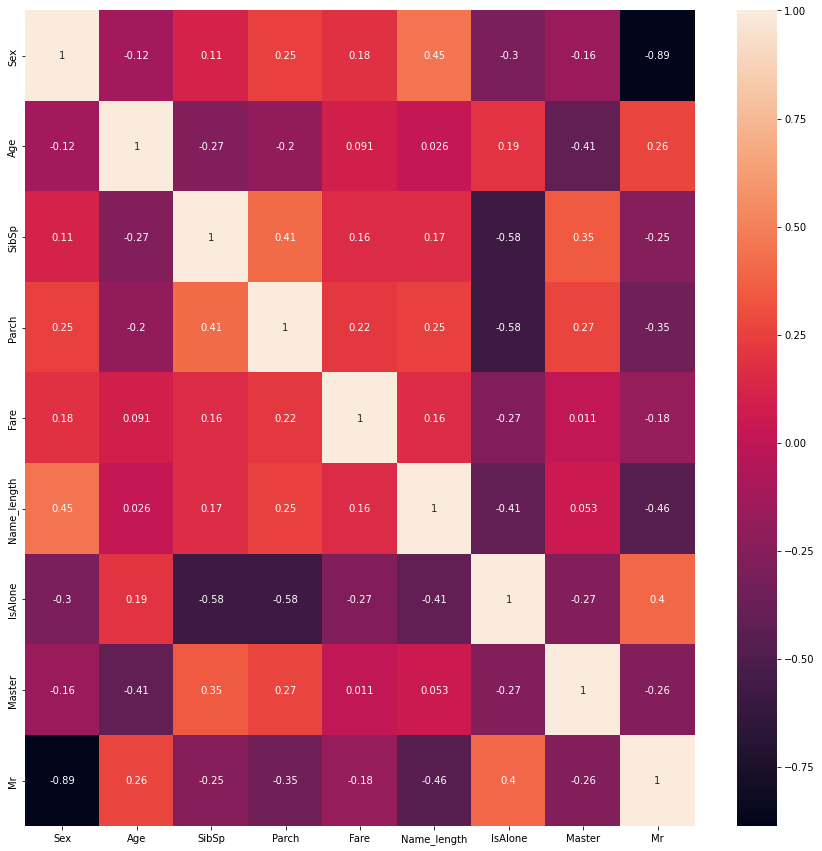

In [13]:
# Correlation Matrix
plt.figure(figsize=(15,15))
cor = X[names].corr() 
sns.heatmap(cor, annot=True,)
plt.show()

### 單變量特徵選取 Univariate Selection

In [14]:
def univariate_selection(X, Y, k=10):
    
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, stratify=Y, random_state = 9527)
    
    scaler = StandardScaler().fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # User SelectKBest to select top 10 features based on f-test
    selector = SelectKBest(f_classif)
    X_new = selector.fit_transform(X_train_scaled, Y_train)

    feature_idx = selector.get_support()

    feature_names = X.columns[feature_idx]
    
    return feature_names

In [15]:
univariate_selection(X,Y)

Index(['Pclass', 'Sex', 'Age', 'Parch', 'Fare', 'Name_length', 'IsAlone',
       'Miss', 'Mr', 'Mrs'],
      dtype='object')

In [16]:
res = res.append(
    pd.DataFrame(
        use_RandomForestClassifier_evaluation_metrics_on_test_set(
            X[univariate_selection(X,Y)],
            Y), 
            index=['Univariate Selection']))
res

,accuracy,roc,precision,recall,f1,Feature Count
ALL,0.815642,0.793281,0.800000,0.695652,0.744186,16
Remove High Corr,0.782123,0.766008,0.727273,0.695652,0.711111,9
Univariate Selection,0.810056,0.794137,0.769231,0.724638,0.746269,10


## 包裝方法 Wrapper Method

### 遞迴特徵消除 Recursive feature elimination (RFE)

In [17]:
# Recursive Feature Elimination
def rfe_selection( X , Y, k=10):
    
    # Split train and test sets
    X_train, X_test, Y_train, Y_test = train_test_split(
        X, 
        Y, 
        test_size = 0.2, 
        stratify=Y, 
        random_state = 9527)
    
    scaler = StandardScaler().fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    model = RandomForestClassifier(
        criterion='entropy', 
        random_state=9527
        )
    rfe = RFE(model)
    rfe = rfe.fit(X_train_scaled, Y_train)

    feature_names = X.columns[rfe.get_support()]
    
    return feature_names


In [18]:
rfe_selection(X,Y,10)

Index(['PassengerId', 'Pclass', 'Sex', 'Age', 'Fare', 'FamilySize',
       'Name_length', 'Mr'],
      dtype='object')

In [19]:
res = res.append(
    pd.DataFrame(
        use_RandomForestClassifier_evaluation_metrics_on_test_set(
            X[rfe_selection(X,Y)],
            Y), 
            index=['RFE']))

res

,accuracy,roc,precision,recall,f1,Feature Count
ALL,0.815642,0.793281,0.800000,0.695652,0.744186,16
Remove High Corr,0.782123,0.766008,0.727273,0.695652,0.711111,9
Univariate Selection,0.810056,0.794137,0.769231,0.724638,0.746269,10
RFE,0.815642,0.790580,0.810345,0.681159,0.740157,8


## 嵌入方法 Embedded Method

### 重要特徵 Feature importance

In [20]:
def feature_importance(X,Y):
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2,stratify=Y, random_state = 9527)
    
    scaler = StandardScaler().fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    model = RandomForestClassifier()
    model = model.fit(X_train_scaled,Y_train)

    plt.figure(figsize=(10, 12))
    feat_importances = pd.Series(model.feature_importances_, index=X.columns)
    feat_importances.sort_values().plot(kind='barh')

    plt.show()
    return model


def select_features_from_model(model,X):
    
    model = SelectFromModel(model, prefit=True, threshold=0.013)
    feature_idx = model.get_support()
    feature_names = X.columns[feature_idx]
        
    return feature_names


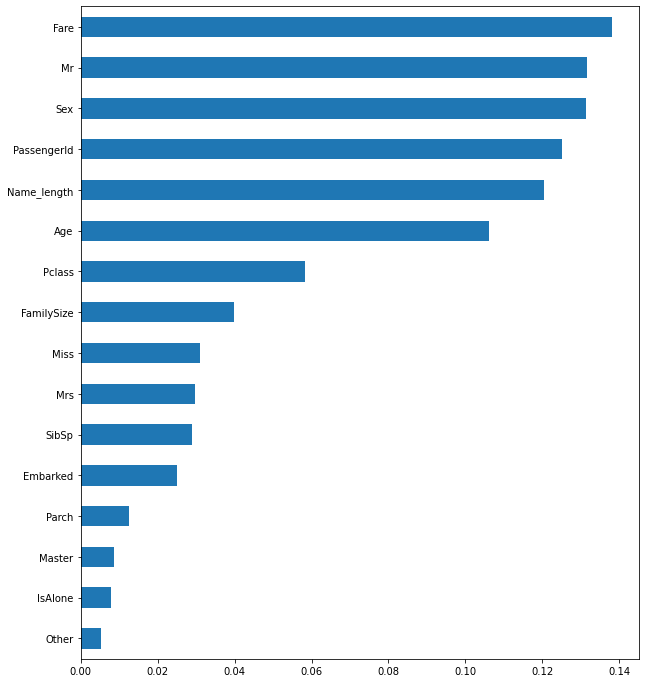

In [21]:
model = feature_importance(X,Y)
feature_imp_feature_names = select_features_from_model(model,X)

In [22]:
feature_imp_feature_names

Index(['PassengerId', 'Pclass', 'Sex', 'Age', 'SibSp', 'Fare', 'Embarked',
       'FamilySize', 'Name_length', 'Miss', 'Mr', 'Mrs'],
      dtype='object')

In [23]:
res = res.append(
    pd.DataFrame(
        use_RandomForestClassifier_evaluation_metrics_on_test_set(
            X[feature_imp_feature_names],
            Y), 
            index=['Feature Importance']))
res

,accuracy,roc,precision,recall,f1,Feature Count
ALL,0.815642,0.793281,0.800000,0.695652,0.744186,16
Remove High Corr,0.782123,0.766008,0.727273,0.695652,0.711111,9
Univariate Selection,0.810056,0.794137,0.769231,0.724638,0.746269,10
RFE,0.815642,0.790580,0.810345,0.681159,0.740157,8
Feature Importance,0.810056,0.783333,0.807018,0.666667,0.730159,12


### L1正規化 L1 regularization

In [24]:
def run_l1_regularization(X,Y):
    
    # Split train and test set
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2,stratify=Y, random_state = 123)
    
    # All features of dataset are float values. You normalize all features of the train and test dataset here.
    scaler = StandardScaler().fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Select L1 regulated features from LinearSVC output 
    selection = SelectFromModel(LinearSVC(C=1, penalty='l1', dual=False))
    selection.fit(X_train_scaled, Y_train)

    feature_names = X.columns[(selection.get_support())]
    
    return feature_names

l1reg_feature_names = run_l1_regularization(X,Y)

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


In [25]:
res = res.append(
    pd.DataFrame(
        use_RandomForestClassifier_evaluation_metrics_on_test_set(
            X[run_l1_regularization(X,Y)],
            Y), 
            index=['L1']))
res

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


,accuracy,roc,precision,recall,f1,Feature Count
ALL,0.815642,0.793281,0.800000,0.695652,0.744186,16
Remove High Corr,0.782123,0.766008,0.727273,0.695652,0.711111,9
Univariate Selection,0.810056,0.794137,0.769231,0.724638,0.746269,10
RFE,0.815642,0.790580,0.810345,0.681159,0.740157,8
Feature Importance,0.810056,0.783333,0.807018,0.666667,0.730159,12
L1,0.810056,0.786034,0.796610,0.681159,0.734375,14


## 評估小結

In [26]:
final_res = pd.DataFrame(use_RandomForestClassifier_evaluation_metrics_on_test_set(X,Y), index=['ALL'])
final_res = final_res.append(pd.DataFrame(use_RandomForestClassifier_evaluation_metrics_on_test_set(X[names],Y), index=['Remove High Corr']))
final_res = final_res.append(pd.DataFrame(use_RandomForestClassifier_evaluation_metrics_on_test_set(X[univariate_selection(X,Y)],Y), index=['Univariate Selection']))
final_res = final_res.append(pd.DataFrame(use_RandomForestClassifier_evaluation_metrics_on_test_set(X[rfe_selection(X,Y)],Y), index=['RFE']))
final_res = final_res.append(pd.DataFrame(use_RandomForestClassifier_evaluation_metrics_on_test_set(X[run_l1_regularization(X,Y)],Y), index=['L1']))
final_res.sort_values('accuracy', ascending=False)

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


,accuracy,roc,precision,recall,f1,Feature Count
ALL,0.815642,0.793281,0.800000,0.695652,0.744186,16
RFE,0.815642,0.790580,0.810345,0.681159,0.740157,8
L1,0.815642,0.793281,0.800000,0.695652,0.744186,13
Univariate Selection,0.810056,0.794137,0.769231,0.724638,0.746269,10
Remove High Corr,0.782123,0.766008,0.727273,0.695652,0.711111,9


## 參考


- [鐵達尼號資料集](https://raw.githubusercontent.com/duxuhao/Feature-Selection/master/example/titanic/clean_train.csv)
- [Machine Learning Data Lifecycle in Production](https://www.coursera.org/learn/machine-learning-data-lifecycle-in-production)
- [Machine Learning Engineering for Production (MLOps) 專項課程](https://www.coursera.org/specializations/machine-learning-engineering-for-production-mlops)